<a href="https://colab.research.google.com/github/rex17/Machine-Learning-Practice/blob/master/Fashion_MNIST_Ensemble_Impl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fashion MNIST Ensemble  Predictive Modelling Impl

To build predictive models in Python we use a set of libraries that are imported here. In particular **pandas** and **sklearn** are particularly important.

In [0]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors

from xgboost import XGBClassifier

%matplotlib inline
%qtconsole

In [22]:
ls


fashion-mnist_test.csv   model_compare.PNG  sample_data/
fashion-mnist_train.csv  __pycache__/       TAS_Python_Utilities.py


In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving TAS_Python_Utilities.py to TAS_Python_Utilities.py
User uploaded file "TAS_Python_Utilities.py" with length 2738 bytes


### Load & Partition Data

In [3]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the distribution of the two classes

In [0]:
dataset["label"].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [0]:
display(dataset.select_dtypes(include=[np.number]).describe())


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


Isolate the descriptive features we are interested in

In [0]:
X = dataset.iloc[:,1:]
Y = dataset["label"]

In [0]:
X_test = test_dataset.iloc[:,1:]
y_test = test_dataset["label"]

In [0]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
Y.head()

0    2
1    9
2    6
3    0
4    3
Name: label, dtype: int64

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [7]:
X_train, X_valid, y_train, y_valid \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)
    


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Decision Tree on Fashion MNIST

Train a decision tree

In [0]:
my_tree = \
    tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Visualise the decision tree so we can see what it is doing!

In [0]:
feature_names = list(X_train.columns)
visualize_tree(my_tree, feature_names)

### Evaluating Model Performance

Assess the performance of the decision tree on the training set

In [0]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = \
metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4201
          1       1.00      1.00      1.00      4157
          2       1.00      1.00      1.00      4192
          3       1.00      1.00      1.00      4151
          4       1.00      1.00      1.00      4235
          5       1.00      1.00      1.00      4214
          6       1.00      1.00      1.00      4213
          7       1.00      1.00      1.00      4211
          8       1.00      1.00      1.00      4205
          9       1.00      1.00      1.00      4221

avg / total       1.00      1.00      1.00     42000

[[4201    0    0    0    0    0    0    0    0    0]
 [   0 4157    0    0    0    0    0    0    0    0]
 [   0    0 4192    0    0    0    0    0    0    0]
 [   0    0    0 4151    0    0    0    0    0    0]
 [   0    0    0    0 4235    0    0    0    0    0]
 [   0    0    0    0    0 4214    0    0    0    0]
 [   0    0    0    0    0   

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,4201,0,0,0,0,0,0,0,0,0,4201
1,0,4157,0,0,0,0,0,0,0,0,4157
2,0,0,4192,0,0,0,0,0,0,0,4192
3,0,0,0,4151,0,0,0,0,0,0,4151
4,0,0,0,0,4235,0,0,0,0,0,4235
5,0,0,0,0,0,4214,0,0,0,0,4214
6,0,0,0,0,0,0,4213,0,0,0,4213
7,0,0,0,0,0,0,0,4211,0,0,4211
8,0,0,0,0,0,0,0,0,4205,0,4205


Assess the performance of the tree on the validation dataset

In [0]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.805166666667
             precision    recall  f1-score   support

          0       0.75      0.76      0.75      1799
          1       0.94      0.94      0.94      1843
          2       0.69      0.71      0.70      1808
          3       0.81      0.80      0.81      1849
          4       0.70      0.69      0.69      1765
          5       0.91      0.90      0.91      1786
          6       0.55      0.55      0.55      1787
          7       0.88      0.88      0.88      1789
          8       0.92      0.91      0.92      1795
          9       0.89      0.91      0.90      1779

avg / total       0.81      0.81      0.81     18000

[[1360   12   40   81   16    4  262    0   23    1]
 [   8 1738   14   53    8    0   17    0    5    0]
 [  34    5 1283   23  207    0  238    0   17    1]
 [  88   62   35 1481   98    2   67    0   14    2]
 [  19    6  237   89 1220    0  183    0    9    2]
 [   2    2    3    7    2 1607    1   84   24   54]
 [ 288   14  220  

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1360,12,40,81,16,4,262,0,23,1,1799
1,8,1738,14,53,8,0,17,0,5,0,1843
2,34,5,1283,23,207,0,238,0,17,1,1808
3,88,62,35,1481,98,2,67,0,14,2,1849
4,19,6,237,89,1220,0,183,0,9,2,1765
5,2,2,3,7,2,1607,1,84,24,54,1786
6,288,14,220,59,181,5,976,0,43,1,1787
7,0,0,0,0,0,86,0,1578,4,121,1789
8,18,3,21,23,20,18,34,11,1636,11,1795


Generate probability score based ROC evaluation metrics

In [0]:
# Make a set of predictions for the validation data
y_pred_score = my_tree.predict_proba(X_valid)
y_pred = my_tree.predict(X_valid)
print(metrics.roc_auc_score(y_valid, y_pred_score[:, 1]))
fpr, tpr, thresh = metrics.roc_curve(y_valid, y_pred_score[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)

### Alternative Trees

Train a decision tree, limiting its depth to 2

In [0]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=2)
my_tree = my_tree.fit(X_train,y_train)

Assess the performance of the decision tree on the **training set**

In [0]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.342285714286
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      4201
          1       0.31      0.96      0.47      4157
          2       0.31      0.97      0.46      4192
          3       0.00      0.00      0.00      4151
          4       0.00      0.00      0.00      4235
          5       0.00      0.00      0.00      4214
          6       0.00      0.00      0.00      4213
          7       0.32      0.99      0.48      4211
          8       0.71      0.52      0.60      4205
          9       0.00      0.00      0.00      4221

avg / total       0.17      0.34      0.20     42000

Confusion Matrix


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,1,2,7,8,All
True,,,,,
0,3655,397,18,131,4201
1,3977,111,28,41,4157
2,88,4049,5,50,4192
3,3208,503,290,150,4151
4,438,3735,3,59,4235
5,27,27,3940,220,4214
6,1226,2863,12,112,4213
7,0,0,4159,52,4211
8,88,1519,407,2191,4205


Assess the performance of the decision tree on the **validation set**

In [0]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.343611111111
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1799
          1       0.31      0.95      0.47      1843
          2       0.31      0.97      0.47      1808
          3       0.00      0.00      0.00      1849
          4       0.00      0.00      0.00      1765
          5       0.00      0.00      0.00      1786
          6       0.00      0.00      0.00      1787
          7       0.32      0.99      0.48      1789
          8       0.72      0.51      0.59      1795
          9       0.00      0.00      0.00      1779

avg / total       0.17      0.34      0.20     18000

Confusion Matrix


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,1,2,7,8,All
True,,,,,
0,1542,197,6,54,1799
1,1752,60,13,18,1843
2,32,1760,3,13,1808
3,1459,204,123,63,1849
4,210,1530,4,21,1765
5,14,8,1682,82,1786
6,521,1200,9,57,1787
7,0,0,1765,24,1789
8,35,693,159,908,1795


Generate probability score based ROC evaluation metrics

In [0]:
# Make a set of predictions for the validation data
y_pred_score = my_tree.predict_proba(X_valid)
print(metrics.roc_auc_score(y_valid, y_pred_score[:, 1]))
fpr, tpr, thresh = metrics.roc_curve(y_valid, y_pred_score[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)

Visualise the decision tree so we can see what it is doing!

In [0]:
# visualise the decision tree
feature_names = list(X_train.columns)
visualize_tree(my_tree, feature_names, fileName="dt_under.png")
Image(filename='dt_under.png') 

## Perform a Cross Validation Experiment

Use a cross validation to perfrom an evaluation

In [0]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_valid, y_valid, cv=10)
print(scores)
scores = pd.Series(scores)
print(scores.mean(), " =/- ", scores.std())

[ 0.77537438  0.79478647  0.79145868  0.77968923  0.79300777  0.78166667
  0.78210117  0.79866518  0.78074569  0.78750697]
0.7865002202678522  =/-  0.007678250510931227


## Choosing Parameters Using a Grid Search

In [0]:
my_tree.fit(X_train, y_train)
my_tree.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

An alternative to using post pruning explicitly is to use a grid search through a large set of possible parameters. Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [0]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 20, 3)), \
             'min_samples_split': [50] }

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=2, verbose = 0, \
                            return_train_score=True)
my_tuned_tree.fit(X_train, y_train)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 50}

0.79145238095238091

{'mean_fit_time': array([  1.97686625,   3.67689574,   5.67024732,   7.07295132,
          8.76948059,  10.12770414,   2.57702649,   6.53277338,
          9.08779871,  11.08865249,  12.06559551,  12.37891531]),
 'mean_score_time': array([ 0.0799551 ,  0.08544981,  0.08345187,  0.08045506,  0.08095503,
         0.08445048,  0.09144545,  0.09543419,  0.07795787,  0.08195364,
         0.08244288,  0.08195424]),
 'mean_test_score': array([ 0.50069048,  0.72478571,  0.78002381,  0.78664286,  0.78552381,
         0.78045238,  0.52452381,  0.73097619,  0.78580952,  0.79145238,
         0.78866667,  0.78897619]),
 'mean_train_score': array([ 0.50302449,  0.73940505,  0.8167388 ,  0.85859478,  0.87292862,
         0.87757165,  0.52726376,  0.74997764,  0.82664473,  0.85959605,
         0.87235712,  0.87392846]),
 'param_criterion': masked_array(data = ['gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'entropy' 'entropy' 'entropy'
  'entropy' 'entropy' 'entropy'],
              mask = [False False Fals

In [0]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8135
             precision    recall  f1-score   support

          0       0.76      0.76      0.76      1000
          1       0.95      0.94      0.94      1000
          2       0.73      0.71      0.72      1000
          3       0.86      0.81      0.83      1000
          4       0.70      0.79      0.74      1000
          5       0.91      0.86      0.89      1000
          6       0.59      0.56      0.57      1000
          7       0.84      0.90      0.87      1000
          8       0.90      0.92      0.91      1000
          9       0.91      0.89      0.90      1000

avg / total       0.81      0.81      0.81     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,761,4,15,39,3,3,151,0,24,0,1000
1,10,940,3,30,6,0,7,0,4,0,1000
2,12,1,706,10,162,1,97,0,11,0,1000
3,42,33,12,810,57,0,41,0,5,0,1000
4,4,1,99,22,791,0,80,0,3,0,1000
5,6,4,3,0,0,860,0,84,22,21,1000
6,151,7,121,27,108,0,564,0,22,0,1000
7,0,0,0,0,0,38,0,896,4,62,1000
8,10,1,10,4,7,18,21,10,918,1,1000


In [0]:
best_tree = tree.DecisionTreeClassifier(min_samples_split=50, criterion='gini', max_depth=8)
best_tree = best_tree.fit(X_train, y_train)

# visualise the decision tree
feature_names = list(X_train.columns)
visualize_tree(best_tree, feature_names, 'dt_tuned.png')


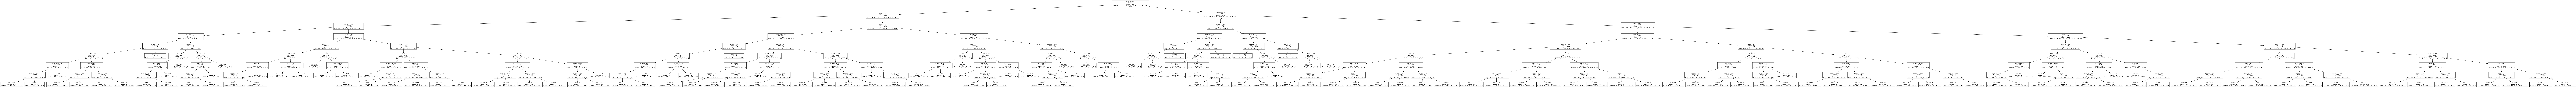

In [30]:
Image(filename='dt_tuned.png') 

### Final Evaluation on Test Set

Evaluate the model on a stratified test set

In [0]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

             precision    recall  f1-score   support

          0       0.76      0.76      0.76      1000
          1       0.95      0.94      0.94      1000
          2       0.73      0.71      0.72      1000
          3       0.86      0.81      0.83      1000
          4       0.70      0.79      0.74      1000
          5       0.91      0.86      0.89      1000
          6       0.59      0.56      0.57      1000
          7       0.84      0.90      0.87      1000
          8       0.90      0.92      0.91      1000
          9       0.91      0.89      0.90      1000

avg / total       0.81      0.81      0.81     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,761,4,15,39,3,3,151,0,24,0,1000
1,10,940,3,30,6,0,7,0,4,0,1000
2,12,1,706,10,162,1,97,0,11,0,1000
3,42,33,12,810,57,0,41,0,5,0,1000
4,4,1,99,22,791,0,80,0,3,0,1000
5,6,4,3,0,0,860,0,84,22,21,1000
6,151,7,121,27,108,0,564,0,22,0,1000
7,0,0,0,0,0,38,0,896,4,62,1000
8,10,1,10,4,7,18,21,10,918,1,1000


### Other Models

We can easily use the same patterns to train other types of models.

#### Random Forests

In [0]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Assess the performance of the model on the **validation set**

In [0]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

             precision    recall  f1-score   support

          0       0.75      0.82      0.78      1799
          1       1.00      0.93      0.96      1843
          2       0.71      0.78      0.74      1808
          3       0.77      0.91      0.84      1849
          4       0.70      0.75      0.72      1765
          5       0.95      0.91      0.93      1786
          6       0.72      0.41      0.52      1787
          7       0.90      0.90      0.90      1789
          8       0.90      0.96      0.93      1795
          9       0.91      0.94      0.93      1779

avg / total       0.83      0.83      0.83     18000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1475,1,43,152,14,3,71,0,40,0,1799
1,3,1720,39,70,3,0,6,0,2,0,1843
2,5,0,1409,15,267,0,82,0,30,0,1808
3,51,2,15,1687,53,0,37,0,4,0,1849
4,7,1,203,150,1316,0,72,0,16,0,1765
5,0,0,0,2,0,1632,0,101,15,36,1786
6,423,2,263,94,208,2,725,0,70,0,1787
7,0,0,0,0,0,46,0,1615,3,125,1789
8,4,0,20,15,11,4,10,5,1724,2,1795


#### Bagging

In [0]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [0]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

             precision    recall  f1-score   support

          0       0.79      0.83      0.81      1799
          1       0.97      0.91      0.94      1843
          2       0.73      0.79      0.76      1808
          3       0.80      0.87      0.84      1849
          4       0.72      0.79      0.75      1765
          5       0.94      0.88      0.91      1786
          6       0.72      0.51      0.60      1787
          7       0.89      0.92      0.90      1789
          8       0.89      0.94      0.91      1795
          9       0.91      0.93      0.92      1779

avg / total       0.84      0.84      0.83     18000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1488,12,30,76,9,4,141,0,39,0,1799
1,11,1685,29,94,5,0,12,0,7,0,1843
2,19,3,1425,19,231,2,80,0,29,0,1808
3,77,17,26,1609,83,7,26,0,4,0,1849
4,5,4,171,94,1394,1,82,0,14,0,1765
5,0,7,1,8,0,1567,1,110,40,52,1786
6,289,10,248,72,195,6,910,0,57,0,1787
7,0,0,0,0,0,38,0,1638,12,101,1789
8,4,1,15,25,13,17,19,15,1684,2,1795


#### AdaBoost

In [0]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)

In [0]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

             precision    recall  f1-score   support

          0       0.77      0.68      0.72      1799
          1       0.99      0.94      0.96      1843
          2       0.65      0.66      0.65      1808
          3       0.82      0.85      0.84      1849
          4       0.68      0.63      0.65      1765
          5       0.90      0.91      0.91      1786
          6       0.47      0.57      0.52      1787
          7       0.87      0.87      0.87      1789
          8       0.95      0.93      0.94      1795
          9       0.91      0.90      0.90      1779

avg / total       0.80      0.79      0.80     18000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1218,0,38,93,7,1,423,0,19,0,1799
1,16,1724,17,61,8,0,15,0,2,0,1843
2,11,0,1200,13,240,0,334,0,10,0,1808
3,88,9,15,1578,53,0,103,0,3,0,1849
4,6,0,312,111,1108,0,225,0,3,0,1765
5,0,0,1,3,0,1623,0,104,13,42,1786
6,229,2,253,52,201,1,1026,0,23,0,1787
7,0,0,0,0,0,109,0,1551,5,124,1789
8,10,1,21,8,9,10,64,2,1668,2,1795


#### Logistic Regression

In [0]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Assess the performance of the model on the **validation set**

In [0]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

             precision    recall  f1-score   support

          0       0.79      0.82      0.80      1799
          1       0.94      0.97      0.95      1843
          2       0.75      0.78      0.76      1808
          3       0.84      0.87      0.86      1849
          4       0.73      0.78      0.75      1765
          5       0.93      0.91      0.92      1786
          6       0.67      0.54      0.59      1787
          7       0.91      0.93      0.92      1789
          8       0.92      0.93      0.92      1795
          9       0.94      0.94      0.94      1779

avg / total       0.84      0.84      0.84     18000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1467,13,30,93,13,5,150,0,27,1,1799
1,5,1782,12,30,6,0,7,0,1,0,1843
2,27,7,1404,16,231,1,105,0,17,0,1808
3,63,36,28,1610,63,3,43,0,2,1,1849
4,6,14,164,59,1372,1,138,0,11,0,1765
5,2,7,3,0,1,1619,8,80,26,40,1786
6,267,20,225,75,187,5,959,0,49,0,1787
7,0,0,0,0,0,65,0,1658,6,60,1789
8,11,15,11,23,14,13,28,12,1662,6,1795


#### Nearest Neighbour

In [0]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

Assess the performance of the decision tree on the **validation set**

In [10]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      1799
           1       0.99      0.96      0.98      1843
           2       0.73      0.82      0.77      1808
           3       0.90      0.88      0.89      1849
           4       0.78      0.76      0.77      1765
           5       0.99      0.81      0.89      1786
           6       0.68      0.58      0.62      1787
           7       0.87      0.95      0.91      1789
           8       0.97      0.95      0.96      1795
           9       0.89      0.97      0.93      1779

   micro avg       0.85      0.85      0.85     18000
   macro avg       0.86      0.85      0.85     18000
weighted avg       0.86      0.85      0.85     18000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1551,1,36,32,11,0,155,1,12,0,1799
1,14,1775,15,31,2,0,6,0,0,0,1843
2,26,0,1485,8,153,0,134,0,2,0,1808
3,94,5,16,1619,69,0,43,0,3,0,1849
4,16,3,209,64,1344,0,126,0,3,0,1765
5,2,0,0,1,1,1450,8,190,7,127,1786
6,326,1,251,28,127,0,1033,0,21,0,1787
7,0,0,0,0,0,7,0,1703,1,78,1789
8,6,0,31,13,14,0,21,6,1698,6,1795


#### XGBoost

In [0]:
# Do the same job with random forests
my_model = XGBClassifier()
my_model = my_model.fit(X_train,y_train)

Assess the performance of the decision tree on the **validation set**

In [12]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1799
           1       0.99      0.97      0.98      1843
           2       0.76      0.80      0.78      1808
           3       0.86      0.89      0.87      1849
           4       0.75      0.78      0.77      1765
           5       0.98      0.93      0.95      1786
           6       0.69      0.57      0.63      1787
           7       0.92      0.94      0.93      1789
           8       0.95      0.95      0.95      1795
           9       0.92      0.95      0.94      1779

   micro avg       0.86      0.86      0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1506,1,30,70,8,3,153,0,28,0,1799
1,4,1782,13,39,1,0,2,0,2,0,1843
2,11,1,1443,14,218,0,107,0,14,0,1808
3,64,8,18,1651,69,0,38,0,1,0,1849
4,6,1,166,81,1383,0,124,0,4,0,1765
5,0,0,0,2,0,1659,0,68,8,49,1786
6,295,2,227,60,145,1,1022,0,35,0,1787
7,0,0,0,0,0,14,0,1676,4,95,1789
8,1,1,12,9,11,8,34,3,1714,2,1795


## Assessing Best Model - XGBoost on Test Data

In [13]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_test)

# Print performance details
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.98      0.98      0.98      1000
           2       0.77      0.78      0.77      1000
           3       0.88      0.90      0.89      1000
           4       0.78      0.81      0.80      1000
           5       0.98      0.93      0.95      1000
           6       0.69      0.60      0.64      1000
           7       0.91      0.92      0.91      1000
           8       0.95      0.96      0.95      1000
           9       0.91      0.95      0.93      1000

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,830,1,13,40,1,1,99,0,15,0,1000
1,3,976,5,13,1,0,2,0,0,0,1000
2,9,0,776,9,124,0,70,0,12,0,1000
3,28,10,10,900,25,1,25,0,1,0,1000
4,1,1,90,34,814,0,57,0,3,0,1000
5,1,0,0,0,0,925,2,50,4,18,1000
6,179,2,105,30,72,0,596,0,16,0,1000
7,0,0,0,0,0,12,0,916,2,70,1000
8,2,2,7,2,3,3,15,2,963,1,1000


**Overall Model Performance Report**

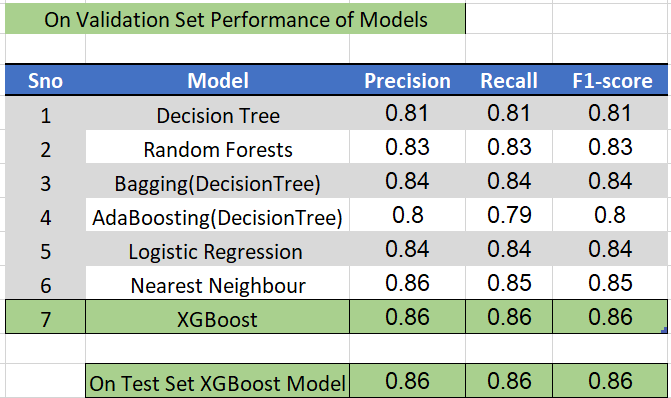

In [24]:
Image("model_compare.PNG")